<div style="background-color: #a83d36; color: #FFFFFF; padding: 10px; text-align: center; border-radius: 15px 15px 5px 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.5);">
  <h1 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold; font-size: 32px;">GestureNet</h1>
</div>

GestureNet is an deep learning model tailored for detecting and recognizing hand sign gestures representing numerical digits, ranging from 1 to 10 classes.

Utilizing a powerful Residual Network (ResNet) architecture with 50 layers, GestureNet incorporates skip connections every 3 layers to enhance model performance and facilitate efficient training.

GestureNet achieves high accuracy in identifying hand sign images, enabling seamless recognition of numerical digits communicated through sign language.

In [ ]:
import tensorflow as tf
import numpy as np
import scipy.misc
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,BatchNormalization
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.python.framework.ops import EagerTensor
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator




<div style="background-color: #642420; color: #FFFFFF; padding: 5px; text-align: center; border-radius: 15px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.5);">
  <h2 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold; font-size: 24px;">Building a Residual Network</h2>
</div>


### The Identity Block

skip connection "skips over" 3 hidden layers 

The upper path is the "shortcut path." The lower path is the "main path." In this diagram, notice the CONV2D and ReLU steps in each layer. To speed up training, a BatchNorm step has been added.

<div style="text-align:center;">
<img src="images/idblock3_kiank.png" style="width:650px;height:150px;">

</div>

In [210]:
# Implementation of the identity block in a Residual Network (ResNet).

def identity_block(X, f, filters, initializer=random_uniform):
    """
    Implementation of the identity block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    initializer -- to set up the initial weights of a layer. Equals to random uniform initializer
    
    Returns:
    X -- output of the identity block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    # padding = 'valid'
    X = Conv2D(filters = F1, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X) # Default axis
    X = Activation('relu')(X)
    

    ## Second component of main path 
    # padding = 'same'
    X = Conv2D(filters = F2, kernel_size = f, strides = (1,1), padding = 'same', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X) # Default axis
    X = Activation('relu')(X)
    

    ## Third component of main path 
    ## padding = 'valid'
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1,1), padding = 'valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X) # Default axis
    
    ## Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


### The Convolutional Block

The ResNet "convolutional block" is the second block type. You can use this type of block when the input and output dimensions don't match up. The difference with the identity block is that there is a CONV2D layer in the shortcut path:

<div style="text-align:center;">
<img src="images/convblock_kiank.png" style="width:650px;height:150px;">
</div>

In [211]:

def convolutional_block(X, f, filters, s = 2, initializer=glorot_uniform):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    s -- Integer, specifying the stride to be used
    initializer -- to set up the initial weights of a layer. Equals to Glorot uniform initializer, 
                   also called Xavier uniform initializer.
    
    Returns:
    X -- output of the convolutional block, tensor of shape (m, n_H, n_W, n_C)
    """
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####

    # First component of main path glorot_uniform(seed=0)
    X = Conv2D(filters = F1, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)


    ## Second component of main path 
    X = Conv2D(filters = F2, kernel_size = f,strides = (1, 1),padding='same',kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    ## Third component of main path 
    X = Conv2D(filters = F3, kernel_size = 1, strides = (1, 1), padding='valid', kernel_initializer = initializer(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)

    ##### SHORTCUT PATH ##### 
    X_shortcut = Conv2D(filters = F3, kernel_size = 1, strides = (s, s), padding='valid', kernel_initializer = initializer(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3)(X_shortcut)



    # Final step: Add shortcut value to main path (Use this order [X, X_shortcut]), and pass it through a RELU activation
    X = tf.keras.layers.Add()([X, X_shortcut])
    X = Activation('relu')(X)
    
    return X

## Building ResNet Model (50 layers)



You now have the necessary blocks to build a very deep ResNet. The following figure describes in detail the architecture of this neural network. "ID BLOCK" in the diagram stands for "Identity block," and "ID BLOCK x3" means you should stack 3 identity blocks together.

<div style="text-align:center;">
<img src="images/resnet_kiank.png" style="width:850px;height:150px;">
</div>

In [227]:
def ResNet50(input_shape = (64, 64, 3), classes = 10, training=False):
    """
    Stage-wise implementation of the architecture of the popular ResNet50:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> FLATTEN -> DENSE 

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    
    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)
    
    # Stage 1
    X = Conv2D(64, (7, 7), strides = (2, 2), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1)
    X = identity_block(X, 3, [64, 64, 256])
    X = identity_block(X, 3, [64, 64, 256])
    

    
    ## Stage 3 
    # `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2)
    
    
    # 3 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])
    X = identity_block(X, 3, [128, 128, 512])

    # Stage 4
    # `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2)
    
    # the 5 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    X = identity_block(X, 3, [256, 256, 1024])
    
    # Stage 5
    # `convolutional_block` with correct values of `f`, `filters` and `s` for this stage
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2)
    
    
    # 2 `identity_block` with correct values of `f` and `filters` for this stage
    X = identity_block(X, 3, [512, 512, 2048])
    X = identity_block(X, 3, [512, 512, 2048])

    X = AveragePooling2D()(X)
    

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=0))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X)

    return model

In [213]:

model = ResNet50(input_shape=(64,64,1),classes=10)
model.summary()


Model: "model_18"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 zero_padding2d_18 (ZeroPad  (None, 70, 70, 1)            0         ['input_21[0][0]']            
 ding2D)                                                                                          
                                                                                                  
 conv2d_976 (Conv2D)         (None, 32, 32, 64)           3200      ['zero_padding2d_18[0][0]']   
                                                                                                  
 batch_normalization_975 (B  (None, 32, 32, 64)           256       ['conv2d_976[0][0]']   



<div style="background-color: #642420; color: #FFFFFF; padding: 5px; text-align: center; border-radius: 15px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.5);">
  <h2 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold; font-size: 24px;">Data Preparation And Model Training</h2>
</div>


In [214]:
# Load the data from the provided files.

X_orig = np.load("archive/X.npy")  
Y_orig = np.load("archive/Y.npy")  

# Print the shapes of the loaded data
print(f'Shape of X: {X_orig.shape}') 
print(f'Shape of Y: {Y_orig.shape}')  


Shape of X: (2062, 64, 64)
Shape of Y: (2062, 10)


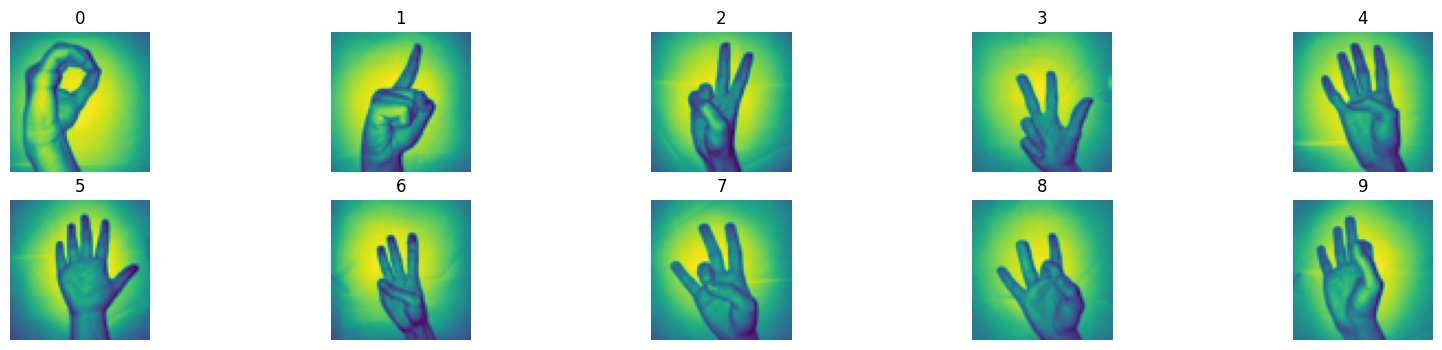

In [215]:

# Organize the input images X_orig according to specific indices to create X_organized

X_organized = np.concatenate((X_orig[204:409, :],  # indices 204 to 408 represent digit 1
                              X_orig[822:1028, :],  # indices 822 to 1027 represent digit 4
                              X_orig[1649:1855, :],  # indices 1649 to 1854 represent digit 8
                              X_orig[1443:1649, :],  # indices 1443 to 1648 represent digit 7
                              X_orig[1236:1443, :],  # indices 1236 to 1442 represent digit 6
                              X_orig[1855:2062, :],  # indices 1855 to 2061 represent digit 9
                              X_orig[615:822, :],  # indices 615 to 821 represent digit 3
                              X_orig[409:615, :],  # indices 409 to 614 represent digit 2
                              X_orig[1028:1236, :],  # indices 1028 to 1235 represent digit 5
                              X_orig[0:204, :]),  # indices 0 to 203 represent digit 0
                             axis=0)

# Plot the organized images
plt.figure(figsize=(20, 4))  # Set the figure size

# Iterate through the indices and plot the images
for i, j in enumerate([0, 208, 411, 617, 823, 1030, 1237, 1444, 1650, 1858]):
    plt.subplot(2, 5, i + 1)  # Create subplots
    plt.imshow(X_organized[j].reshape(64, 64))  # Reshape and plot the image
    plt.title(np.argmax(Y_orig[j]))  # Set the title as the corresponding label
    plt.axis("off")  # Turn off axis


In [216]:
X_orig.shape

(2062, 64, 64)

In [217]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
train_x, test_x, train_y, test_y = train_test_split(X_orig, Y_orig, test_size=0.2)

# Print the shapes of the training and testing sets
print(f'Training set features shape: {train_x.shape}')
print(f'Training set labels shape:   {train_y.shape}')
print(f'Testing set features shape:  {test_x.shape}')
print(f'Testing set labels shape:    {test_y.shape}')



Training set features shape: (1649, 64, 64)
Training set labels shape:   (1649, 10)
Testing set features shape:  (413, 64, 64)
Testing set labels shape:    (413, 10)


In [222]:
# Compile the model with Adam optimizer, categorical crossentropy loss, and accuracy metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training data for 10 epochs with a batch size of 32
history=model.fit(train_x, train_y, epochs = 10, batch_size = 32)

Epoch 1/10
52/52 [==============================] - 76s 1s/step - loss: 0.6624 - accuracy: 0.8338
Epoch 2/10
52/52 [==============================] - 65s 1s/step - loss: 0.2385 - accuracy: 0.9339
Epoch 3/10
52/52 [==============================] - 65s 1s/step - loss: 0.1860 - accuracy: 0.9454
Epoch 4/10
52/52 [==============================] - 64s 1s/step - loss: 0.1268 - accuracy: 0.9673
Epoch 5/10
52/52 [==============================] - 65s 1s/step - loss: 0.1360 - accuracy: 0.9648
Epoch 6/10
52/52 [==============================] - 65s 1s/step - loss: 0.2749 - accuracy: 0.9206
Epoch 7/10
52/52 [==============================] - 64s 1s/step - loss: 0.0843 - accuracy: 0.9776
Epoch 8/10
52/52 [==============================] - 65s 1s/step - loss: 0.1350 - accuracy: 0.9588
Epoch 9/10
52/52 [==============================] - 66s 1s/step - loss: 0.0387 - accuracy: 0.9873
Epoch 10/10
52/52 [==============================] - 66s 1s/step - loss: 0.0447 - accuracy: 0.9879


In [223]:
# Save the trained model to a file named "GestureNet.h5"
model.save("GestureNet.h5")



<div style="background-color: #642420; color: #FFFFFF; padding: 5px; text-align: center; border-radius: 15px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.5);">
  <h2 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold; font-size: 24px;">Model Evaluation and Visualization</h2>
</div>


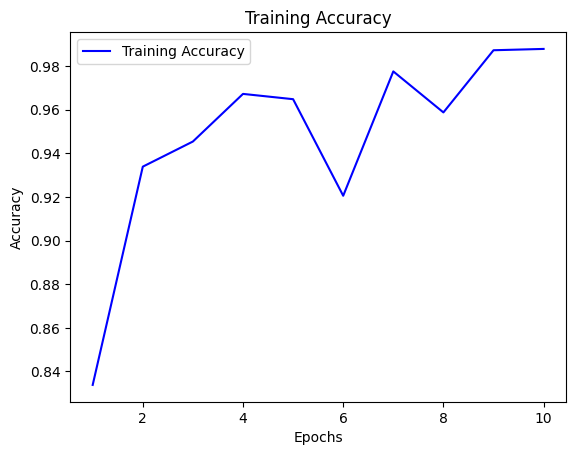

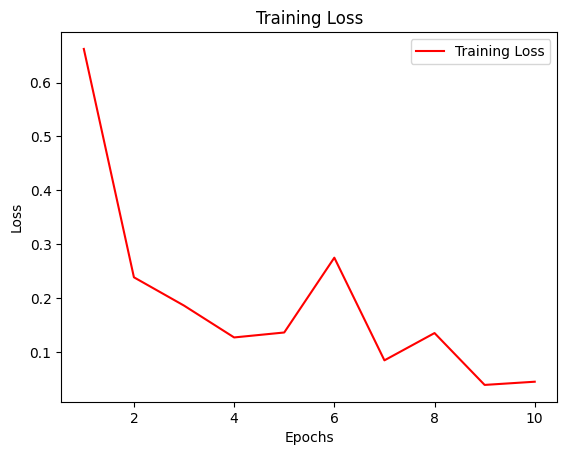

In [224]:
# Get the history of accuracy and loss

accuracy = history.history['accuracy']
loss = history.history['loss']

# Generate a range of epochs
epochs = range(1, len(accuracy) + 1)

# Plotting training accuracy
plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plotting training loss
plt.plot(epochs, loss, 'r', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


13/13 [==============================] - 3s 166ms/step - loss: 0.1108 - accuracy: 0.9709
loss0.11081933975219727
accuracy0.9709442853927612


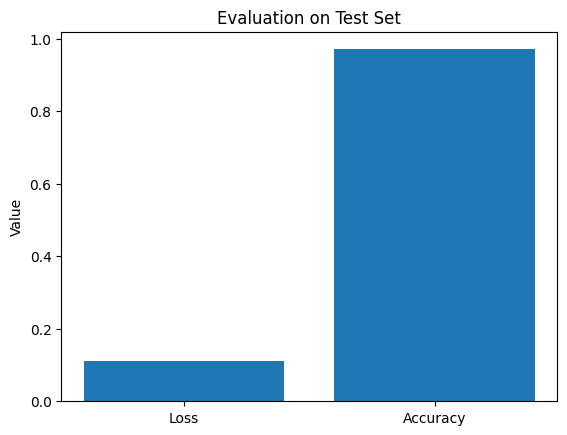

In [225]:
# Evaluate the model on the test set

evals = model.evaluate(test_x,test_y)

print("loss" +str(evals[0]))
print("accuracy" +str(evals[1]))
test_loss = evals[0]
test_accuracy = evals[1]

# Plot the test loss and accuracy
plt.bar(['Loss', 'Accuracy'], [test_loss, test_accuracy])
plt.title('Evaluation on Test Set')
plt.ylabel('Value')
plt.show()
